In [1]:
from google.colab import files
uploaded = files.upload()

Saving Student Survey - Jan.xlsx to Student Survey - Jan.xlsx


In [1]:
import pandas as pd

file_path = "/content/Student Survey - Jan.xlsx"  # Adjust if needed
sheet_dict = pd.read_excel(file_path, sheet_name=None)  # Load all sheets into a dictionary

# Access individual sheets
df_affiliations = sheet_dict.get("affiliations")
df_participants = sheet_dict.get("participants")
df_responses = sheet_dict.get("responses")
df_friends = sheet_dict.get("net_0_Friends")
df_influential = sheet_dict.get("net_1_Influential")
df_feedback = sheet_dict.get("net_2_Feedback")
df_more_time = sheet_dict.get("net_3_MoreTime")
df_advice = sheet_dict.get("net_4_Advice")
df_disrespect = sheet_dict.get("net_5_Disrespect")
df_school_activity = sheet_dict.get("net_affiliation_0_SchoolActivit")

In [3]:
import networkx as nx

Encoding relationships to graphs

In [4]:
# Assuming df_friends is already loaded
# Remove self-loops (where Source == Target)
df_disrespect = df_disrespect[df_disrespect["Source"] != df_disrespect["Target"]]

# Create a directed graph (DiGraph)
G = nx.DiGraph()
for _, row in df_disrespect.iterrows():
    G.add_edge(row["Source"], row["Target"])

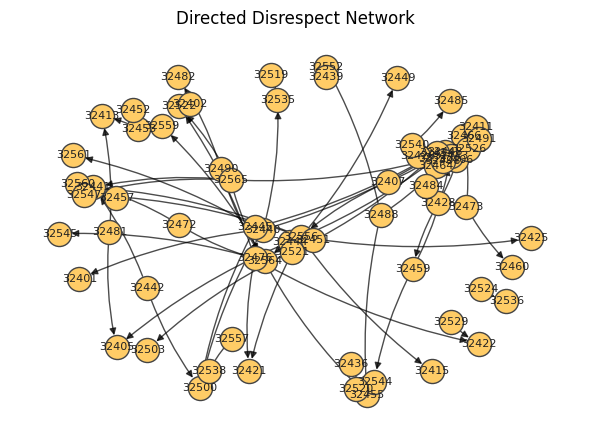

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# ── parameters you can tweak ─────────────────────────────────────────
SHOW_LABELS   = True          # False if too cluttered
NODE_SIZE     = 300           # pixels²
ARROW_SIZE    = 10            # arrow-head scale
EDGE_ALPHA    = 0.7
FIG_W_PER_100 = 4             # width in inches per 100 nodes
# ─────────────────────────────────────────────────────────────────────

def draw_directed_graph(G):
    n = G.number_of_nodes()
    fig_w = max(6, (n / 100) * FIG_W_PER_100)
    fig_h = fig_w * 0.75
    plt.figure(figsize=(fig_w, fig_h))

    # Spring layout (force-directed). For reproducibility, set seed.
    pos = nx.spring_layout(G, k=None, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos,
        node_size=NODE_SIZE,
        node_color="#FFCC66",
        edgecolors="#444"
    )

    # Draw directed edges with arrow-heads
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowsize=ARROW_SIZE,
        alpha=EDGE_ALPHA,
        connectionstyle="arc3,rad=0.08"    # slight curve helps overlap
    )

    # Optional labels
    if SHOW_LABELS:
        nx.draw_networkx_labels(
            G, pos,
            font_size=8,
            font_color="#222"
        )

    plt.axis("off")
    plt.title("Directed Disrespect Network")
    plt.tight_layout()
    plt.show()

# --- call it ---
draw_directed_graph(G)

In [5]:
!pip install python-louvain

In [6]:
def directed_modularity(G, communities):
    """
    Compute directed modularity (Leicht-Newman) for a given partition.

    Q = (1/m) * sum_{c in communities} sum_{i,j in c} [A_ij - (k_out(i) * k_in(j)) / m]

    Parameters:
      G: A NetworkX DiGraph.
      communities: A list of sets, where each set contains the nodes in one community.

    Returns:
      Q: The modularity value.
    """
    m = G.number_of_edges()
    if m == 0:
        return 0
    Q = 0.0
    for community in communities:
        for i in community:
            for j in community:
                A_ij = 1 if G.has_edge(i, j) else 0
                k_out_i = G.out_degree(i)
                k_in_j = G.in_degree(j)
                Q += (A_ij - (k_out_i * k_in_j) / m)
    return Q / m

def greedy_leicht_newman(G):
    """
    A greedy algorithm to optimize directed modularity (Leicht-Newman method).

    Starts with each node in its own community and iteratively merges the pair of communities
    that yields the highest increase in directed modularity.

    Parameters:
      G: A NetworkX DiGraph.

    Returns:
      communities: A list of sets, each set is a community of nodes.
    """
    # Initialize each node as its own community.
    communities = [{node} for node in G.nodes()]
    current_modularity = directed_modularity(G, communities)
    print("Initial modularity:", current_modularity)

    improvement = True
    while improvement:
        improvement = False
        best_delta = 0
        best_pair = None

        # Consider all pairs of communities.
        for i in range(len(communities)):
            for j in range(i + 1, len(communities)):
                merged = communities[i] | communities[j]
                # Form a new partition with communities[i] and communities[j] merged.
                new_communities = [communities[k] for k in range(len(communities)) if k not in (i, j)]
                new_communities.append(merged)
                new_modularity = directed_modularity(G, new_communities)
                delta = new_modularity - current_modularity
                if delta > best_delta:
                    best_delta = delta
                    best_pair = (i, j, merged)

        if best_pair is not None and best_delta > 0:
            i, j, merged = best_pair
            # Merge the best pair of communities.
            communities = [communities[k] for k in range(len(communities)) if k not in (i, j)]
            communities.append(merged)
            current_modularity += best_delta
            print("Merged communities, new modularity:", current_modularity)
            improvement = True

    return communities

# --- Use your existing graph G ---
# Your graph G is already created from your df_friends data:
# import networkx as nx
# df_friends = df_friends[df_friends["Source"] != df_friends["Target"]]
# G = nx.DiGraph()
# for _, row in df_friends.iterrows():
#     G.add_edge(row["Source"], row["Target"])

# Run the greedy Leicht-Newman community detection algorithm on your graph
final_communities = greedy_leicht_newman(G)

# Print out the final communities
print("\nFinal communities:")
for idx, comm in enumerate(final_communities):
    print(f"Community {idx}: {sorted(comm)}")

Initial modularity: -0.005886426592797783
Merged communities, new modularity: 0.007098337950138504
Merged communities, new modularity: 0.02008310249307479
Merged communities, new modularity: 0.03306786703601108
Merged communities, new modularity: 0.046052631578947366
Merged communities, new modularity: 0.05886426592797784
Merged communities, new modularity: 0.07167590027700832
Merged communities, new modularity: 0.0844875346260388
Merged communities, new modularity: 0.09729916897506925
Merged communities, new modularity: 0.11011080332409973
Merged communities, new modularity: 0.12292243767313019
Merged communities, new modularity: 0.13573407202216065
Merged communities, new modularity: 0.1485457063711911
Merged communities, new modularity: 0.16135734072022156
Merged communities, new modularity: 0.174168975069252
Merged communities, new modularity: 0.18680747922437665
Merged communities, new modularity: 0.19944598337950134
Merged communities, new modularity: 0.21191135734072017
Merged c

In [7]:
import networkx as nx
from sklearn.preprocessing import minmax_scale

# ---------- 1. Degree-based bully score  ----------
def bully_score_degree(subg, weight=None):
    in_d  = dict(subg.in_degree(weight=weight))   # # nominations received
    out_d = dict(subg.out_degree(weight=weight))  # # nominations made
    return {n: in_d[n] - out_d[n] for n in subg.nodes()}  # +ve ⇒ likely bully

# ---------- 2. PageRank on the *reversed* graph ----------
def bully_score_pagerank(subg, weight=None, alpha=0.85):
    # Reverse edges so "influential receivers" of disrespect rank highest
    return nx.pagerank(subg, alpha=alpha, weight=weight)

# ---------- 3. Combine & pick top candidate ----------
def combine_scores(deg_dict, pr_dict, w_deg=0.6, w_pr=0.4):
    nodes = list(deg_dict.keys())
    d_s   = minmax_scale([deg_dict[n] for n in nodes])
    p_s   = minmax_scale([pr_dict[n]  for n in nodes])
    return {n: w_deg*d_s[i] + w_pr*p_s[i] for i, n in enumerate(nodes)}

def community_subgraphs(G, communities):
    for cid, nodes in enumerate(communities):
        yield cid, G.subgraph(nodes).copy()

def bully_candidates(G_d, communities, weight=None):
    results = {}
    for cid, subg in community_subgraphs(G_d, communities):
        deg_score = bully_score_degree(subg, weight)
        pr_score  = bully_score_pagerank(subg, weight)
        combo     = combine_scores(deg_score, pr_score)
        bully     = max(combo, key=combo.get)              # top candidate
        ranked    = sorted(combo.items(), key=lambda x: x[1], reverse=True)
        results[cid] = {"primary_bully": bully, "ranking": ranked}
    return results

In [8]:
bully_info  = bully_candidates(G, final_communities)

for cid, info in bully_info.items():
    print(f"Community {cid}: primary bully → {info['primary_bully']}")

Community 0: primary bully → 32536
Community 1: primary bully → 32485
Community 2: primary bully → 32414
Community 3: primary bully → 32405
Community 4: primary bully → 32422
Community 5: primary bully → 32455
Community 6: primary bully → 32466
Community 7: primary bully → 32500
Community 8: primary bully → 32441


<ipython-input-9-5df7cdec0654>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = list(plt.cm.get_cmap("tab20").colors)


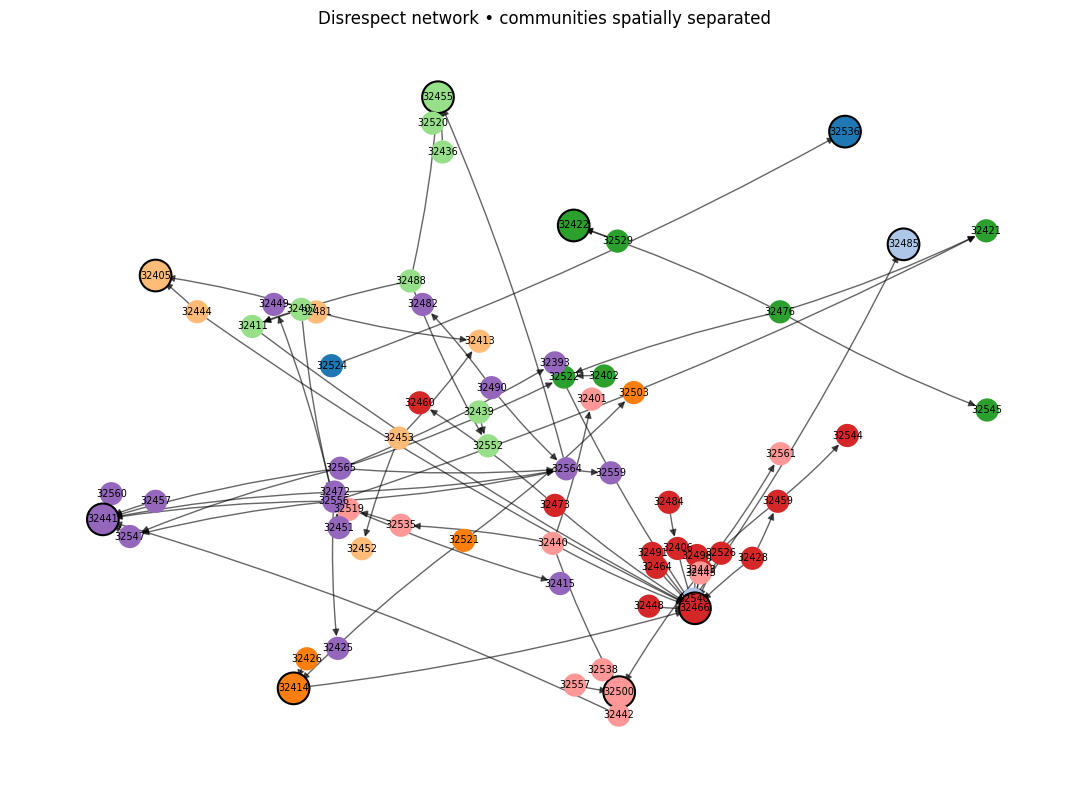

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# ------------------------------------------------------------------
# CONFIG  (tweak if you like)
# ------------------------------------------------------------------
SHOW_LABELS   = True
COMM_PAD      = 3.0     # distance between community centroids
INNER_K       = 0.3     # spring k inside each community
SEED          = 42
NODE_SIZE     = 280
BULLY_SIZE    = 520
EDGE_ALPHA    = 0.6
ARROW_SIZE    = 10
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# Helper: distinct colour palette
# ------------------------------------------------------------------
def get_n_colors(n, seed=1):
    random.seed(seed)
    base = list(plt.cm.get_cmap("tab20").colors)
    if n <= 20:
        return base[:n]
    return [plt.cm.hsv(i / n) for i in range(n)]

# ------------------------------------------------------------------
# Build look-ups
# ------------------------------------------------------------------
# ➊ node → community id
node2comm = {
    n: cid
    for cid, nodes in enumerate(final_communities)
    for n in nodes
}

# ➋ set of primary bully IDs (larger, black outline)
primary_bullies = {info['primary_bully'] for info in bully_info.values()}

# ------------------------------------------------------------------
# 1. Meta-graph: each community → one super-node
# ------------------------------------------------------------------
meta = nx.Graph()
for cid, nodes in enumerate(final_communities):
    meta.add_node(cid, size=len(nodes))

# connect super-nodes if any disrespect edge crosses communities
for u, v in G.edges():
    cu, cv = node2comm[u], node2comm[v]
    if cu != cv:
        meta.add_edge(cu, cv)

meta_pos = nx.spring_layout(meta, k=COMM_PAD, seed=SEED)

# ------------------------------------------------------------------
# 2. Layout each community internally and translate to its anchor
# ------------------------------------------------------------------
full_pos = {}
rng = random.Random(SEED)

for cid, nodes in enumerate(final_communities):
    sub = G.subgraph(nodes).copy()
    inner_pos = nx.spring_layout(sub, k=INNER_K, seed=rng.randint(0, 1_000_000))
    ax, ay = meta_pos[cid]
    for n, (x, y) in inner_pos.items():
        full_pos[n] = (x + ax, y + ay)

# ------------------------------------------------------------------
# 3. Draw
# ------------------------------------------------------------------
colors = get_n_colors(len(final_communities), seed=SEED)
plt.figure(figsize=(11, 8))

# nodes (community-wise so colours don’t mix)
for cid, nodes in enumerate(final_communities):
    nx.draw_networkx_nodes(
        G, full_pos,
        nodelist=list(nodes),
        node_size=[BULLY_SIZE if n in primary_bullies else NODE_SIZE for n in nodes],
        node_color=[colors[cid]] * len(nodes),
        edgecolors=["black" if n in primary_bullies else "none" for n in nodes],
        linewidths=1.5
    )

# edges
nx.draw_networkx_edges(
    G, full_pos,
    arrows=True, arrowsize=ARROW_SIZE,
    width=1, alpha=EDGE_ALPHA,
    connectionstyle="arc3,rad=0.04"
)

# optional tiny labels
if SHOW_LABELS:
    nx.draw_networkx_labels(G, full_pos, font_size=7)

plt.title("Disrespect network • communities spatially separated")
plt.axis("off")
plt.tight_layout()
plt.show()